In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import os
import sys
from   astropy.table       import Table
import numpy as np
from scipy.spatial.distance import cdist
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot   as     plt
from   astropy.coordinates import SkyCoord

In [102]:
photoz = Table.read('/cosma/home/durham/dc-bigw1/data/EAZYPhotoZv02.fits')

In [103]:
sci = Table.read('/cosma/home/durham/dc-bigw1/data/gkvScienceCatv02.fits')

In [104]:
#photoz also in science catalogue 
photoz_small = photoz[np.in1d(photoz['uberID'],sci['uberID'])]['uberID','z_peak']

In [ ]:
catalog.search_around_sky

In [105]:
#combine ra and dec arrays into set of coords
coords = np.concatenate([np.array(sci['RAcen'].data)[:,None],np.array(sci['Deccen'].data)[:,None]], axis=1)

In [106]:
#show we dont go 360->0 so distance measure should be ok
sci['RAcen'][np.argmin(sci['RAcen'])],sci['RAcen'][np.argmax(sci['RAcen'])]

(128.495325185197, 352.307759014651)

In [107]:
sci['Deccen'][np.argmin(sci['Deccen'])],sci['Deccen'][np.argmax(sci['Deccen'])]

(-35.675139095797206, 3.04461713995142)

In [139]:
#index of nearest neighbours of each target in sci catalogue 
neighbours = []

for i in range(len(coords[:1000])):
    #calculate dist for each 
    dists = cdist([coords[i]],coords[:1000])
    #no. neighbours
    k = 6
    #indices of neighbours
    idx = np.argpartition(dists, k)
    neighbours.append(idx[0][:k])

In [134]:
def cartesian(ras, decs, zs, rotate=False):
    phi        = np.radians(ras)
    theta      = np.pi/2. - np.radians(decs)

    mean_phi   = np.median(phi)
    mean_theta = np.median(theta)
    
    chis       = cosmo.comoving_distance(zs).value # [Mpc/h].

    zs         = chis * np.cos(theta)
    ys         = chis * np.sin(theta) * np.sin(phi)
    xs         = chis * np.sin(theta) * np.cos(phi)

    pos        = np.c_[xs, ys, zs]

    if rotate:
        pos    = rotate(ras, decs, pos)

    return  pos

In [ ]:
#run cartesian on catalogue 
#remove own index 

In [135]:
#now use photoz catalogue to get comoving distance between nearest neighbours
comov_dists = []

for i in range(len(coords[:1000])):
    target_z = np.array(photoz_small[(photoz_small['uberID'].data==sci['uberID'].data[i])]['z_peak'].data)
    target_pos = cartesian(coords[i][0],coords[i][1],target_z)
    
    neighbours_pos = []
    for j in range(len(neighbours[i])):
        neighbours_z = np.array(photoz_small[(photoz_small['uberID'].data==sci['uberID'].data[neighbours[i][j]])]['z_peak'].data)
        neighbours_pos.append(cartesian(coords[neighbours[i][j]][0],coords[neighbours[i][j]][1],neighbours_z))
    neighbours_pos = np.array(neighbours_pos)
    
    distSq = (np.square(neighbours_pos - target_pos)).sum(axis=2)
    
    comov_dists.append(np.sqrt(distSq))
    
comov_dists = np.array(comov_dists) 

In [109]:
"""
#now use photoz catalogue to get comoving distance between nearest neighbours
comov_dists = []

for i in range(len(coords[:1000])):
    target_z = np.array(photoz_small[(photoz_small['uberID'].data==sci['uberID'].data[i])]['z_peak'].data)
    neighbours_z = []
    for j in range(len(neighbours[i])):
        neighbours_z.append(np.array(photoz_small[(photoz_small['uberID'].data==sci['uberID'].data[neighbours[i][j]])]['z_peak'].data))
    neighbours_z = np.array(neighbours_z)
    comov_dists.append(np.array(np.abs(cosmo.comoving_distance(neighbours_z-target_z))))
    
comov_dists = np.array(comov_dists) 
"""

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [136]:
min_dist = []
for i in range(len(comov_dists)):
    temp = comov_dists[i][comov_dists[i]>0.]
    
    temp = temp[~ np.isnan(temp)]
    if len(temp)==0:
        min_dist.append(1e12)
    else:
        min_dist.append(temp[np.argmin(temp)])
min_dist = np.array(min_dist)

In [ ]:
#pick small square 

Text(0, 0.5, 'DEC')

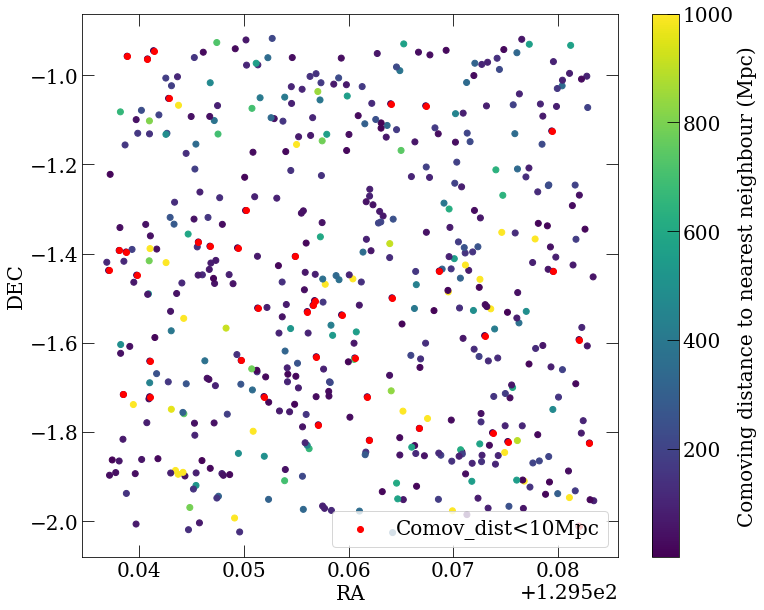

In [132]:
plt.figure(figsize=(12,10))
plt.rc('font', family='serif',size=20)
plt.rc('xtick',direction='in',labelsize=20,top=True)
plt.rc('ytick',direction='in',labelsize=20, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 20)

plt.scatter(sci['RAcen'][:1000][min_dist<1e12],sci['Deccen'][:1000][min_dist<1e12],c=min_dist[min_dist<1e12],vmax=1000)
cbar = plt.colorbar()
cbar.set_label('Comoving distance to nearest neighbour (Mpc)')
plt.scatter(sci['RAcen'][:1000][min_dist<10],sci['Deccen'][:1000][min_dist<10],c='red',label='Comov_dist<10Mpc')
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')